# Sweet Lift Taxi Company - Predicción de Demanda

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

<div class="alert alert-block alert-success">
<b>Review General. (Iteración 1) </b> <a class="tocSkip"></a>

Enrique, quería tomarme este tiempo al inicio de tu proyecto para comentarte mis apreciaciones generales de esta iteración de tu entrega.

Siempre me gusta comenzar dando la bienvenida al mundo de los datos a los estudiantes, te deseo lo mejor y espero que consigas lograr tus objetivos. Personalmente me gusta brindar el siguiente consejo, "Está bien equivocarse, es normal y es lo mejor que te puede pasar. Aprendemos de los errores y eso te hará mejor programador ya que podrás descubrir cosas a medida que avances y son estas cosas las que te darán esa experiencia para ser un gran cientifico de datos."
    
Ahora si yendo a esta notebook.  Enrique quiero felicitarte porque has hecho un gran trabajo a lo largo de toda la notebook, desde las interpretaciones hasta las implementaciones, se ha notado un gran manejo de las herramientas y una gran comprensión de los resultados obtenidos. Felicitaciones Enrique, tu trabajo esta en las mejores condiciones para ser aprobado.

Éxitos dentro de tu camino en el mundo de los datos, saludos!

## Introducción.

Para desarrollar este proyecto, vamos a trabajar con los datos de la compañía Sweet Lift Taxi. Se han recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Para lo cual debemos construir un modelo para dicha predicción.

Para ello vamos a trabajar con varios modelos con ajuste de hiperparámetros:

- Modelo de Árbol de Decisión

- Modelo de Regresión Lineal

- Modelo de Bosque Aleatorio

- Modelo LightGBM


Utilizaremos la métrica RECM para evaluar el desempeño de cada uno los modelos.


## Preparación de datos

Primero procedemos a importar Librerías:

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

Leemos el Conjunto de Datos con la información de la compañía Sweet Lift Taxi:

In [2]:
# Carga de datos y conversión de datos
data = pd.read_csv("/datasets/taxi.csv",parse_dates=[0], index_col=[0])

La carga del archivo CSV está configurada para interpretar la primera columna como fechas (parse_dates=[0]) y usarla como índice (index_col=[0]).

In [36]:
# Imprimimos la información general/resumida del conjunto de datos.
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


- La columna datetime se ha convertido correctamente en el índice del DataFrame.
- El conjunto de datos tiene 26,496 entradas con un rango de fechas desde 2018-03-01 00:00:00 hasta 2018-08-31 23:50:00.
- La columna num_orders no tiene valores nulos y es de tipo int64.

In [5]:
# Vista de los primeros registros
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


- Los datos están registrados en intervalos de 10 minutos.

In [6]:
# Ordenamos el índice de la tabla
data.sort_index(inplace=True)

print(data.index.is_monotonic)

True


- El índice se ha ordenado correctamente y es monotónico (ordenado cronológicamente).

In [7]:
# Estadísticas descriptivas
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


count: 26496.000000
Este valor indica que hay 26,496 registros en la columna num_orders. Esto significa que el DataFrame tiene 26,496 filas con datos no nulos en esta columna.

mean: 14.070463
El valor promedio de num_orders es aproximadamente 14.07. Esto indica que, en promedio, hay alrededor de 14 pedidos de taxis por cada intervalo de tiempo registrado.

std: 9.211330
La desviación estándar es aproximadamente 9.21. Esto muestra la variabilidad de los datos alrededor de la media. Una desviación estándar más alta indica una mayor dispersión en el número de pedidos de taxis.

Los cuartiles (25%, 50%, 75%) y la media sugieren que la mayoría de los valores están concentrados entre 8 y 19, con algunos valores más altos que se consideran atípicos.

Para comprender mejor la distribución de los datos agregamos a continuación un histograma, a través del cual confirmamos que la mayoría de los valores están concentrados entre 8 y 19 pedidos.


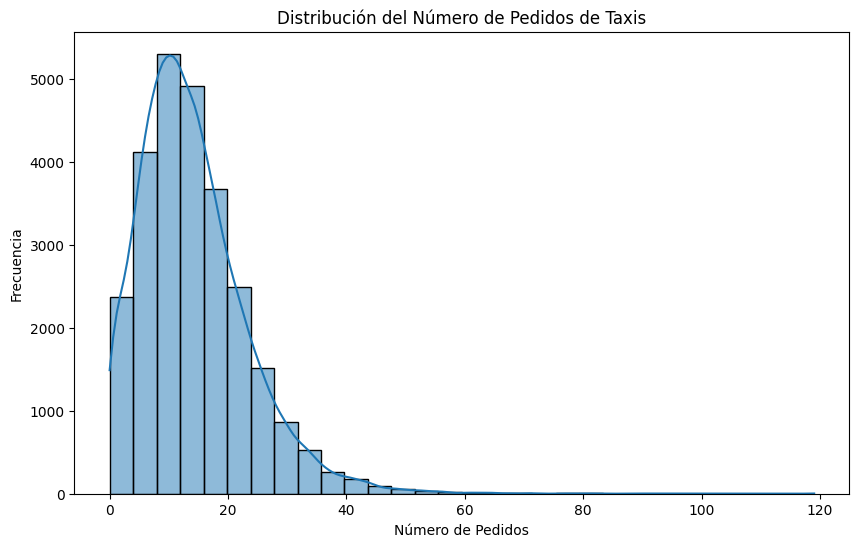

In [8]:
# Histograma
plt.figure(figsize=(10, 6))
sns.histplot(data['num_orders'], bins=30, kde=True)
plt.title('Distribución del Número de Pedidos de Taxis')
plt.xlabel('Número de Pedidos')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
# Verificación de valores nulos
total_nulos = data.isna().sum().sum()
print(f'Número total de valores nulos en el DataFrame: {total_nulos}')

Número total de valores nulos en el DataFrame: 0


In [10]:
# Remuestrear los datos a intervalos de una hora utilizando la media
data_resampled = data.resample("1H").mean()

In [11]:
data_resampled.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667


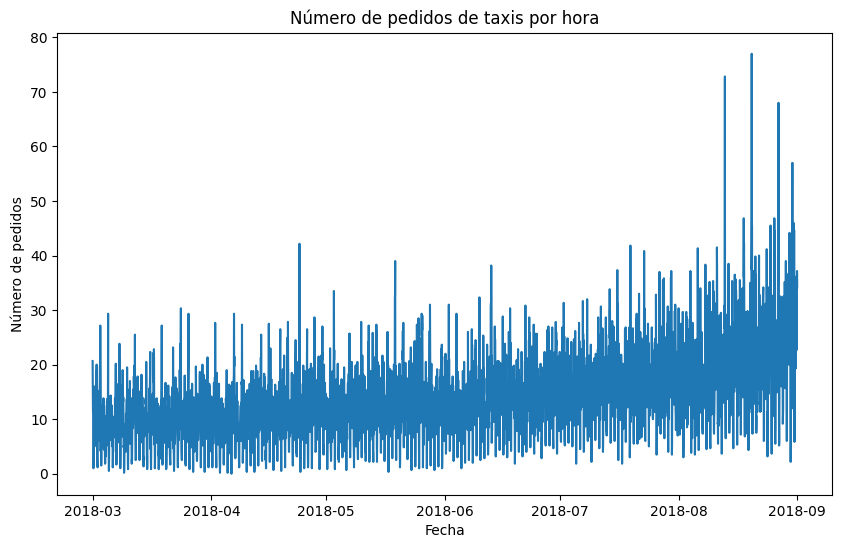

In [12]:
# Visualización de los datos remuestreados
plt.figure(figsize=(10, 6))
plt.plot(data_resampled.index, data_resampled['num_orders'])
plt.title('Número de pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.show()

Del gráfico podemos ver que hay una tendencia general ascendente en el número de pedidos de taxis a lo largo del tiempo.

Especialmente hacia el final del período, se observa un aumento significativo en los pedidos.

Para continuar con el análisis, vamos a descomponer la serie temporal en componentes de tendencia, estacionalidad y residuales puede ayudar a identificar patrones específicos.

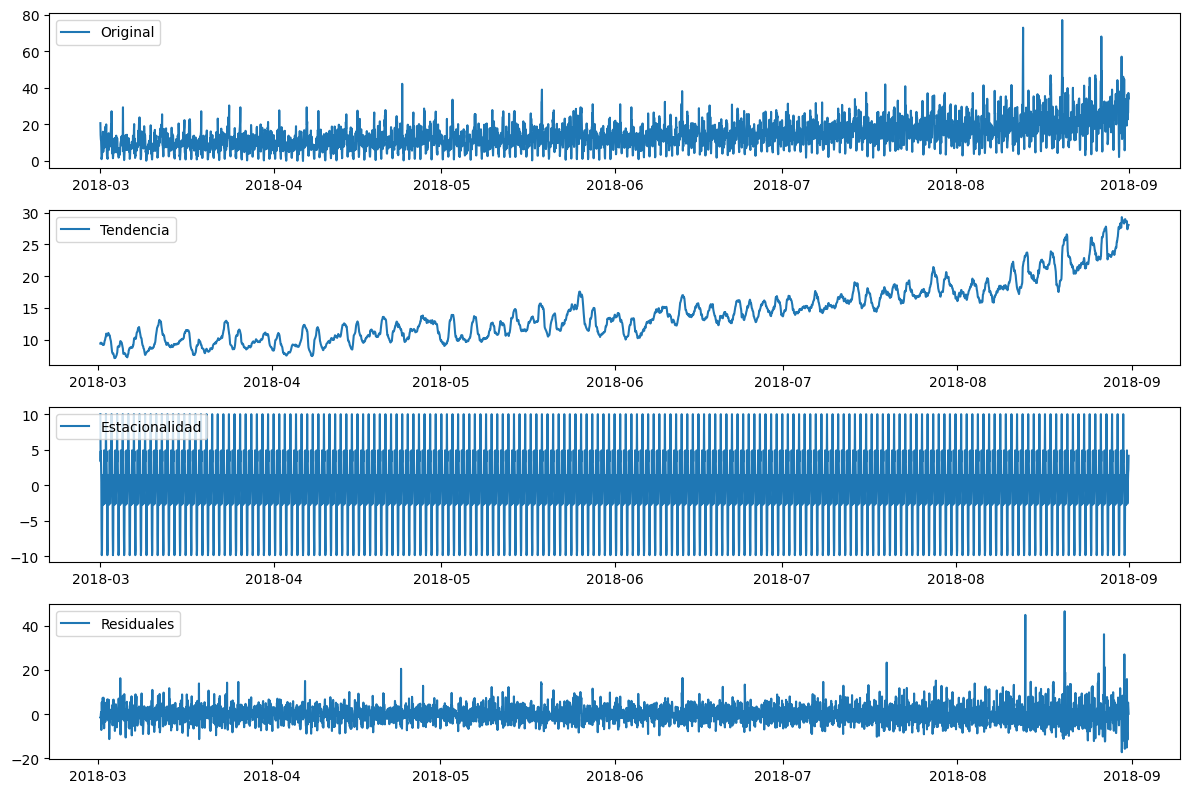

In [13]:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(data_resampled['num_orders'], model='additive')

# Visualización de la descomposición
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data_resampled['num_orders'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuales')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Análisis de la Descomposición
Serie Original:
Muestra el número total de pedidos de taxis por hora a lo largo del tiempo.
Se observa la misma tendencia ascendente y la variabilidad creciente que notamos anteriormente.

Tendencia:
La tendencia muestra un aumento gradual y constante en el número de pedidos de taxis a lo largo del tiempo.
Esto sugiere que hay un crecimiento subyacente en la demanda de taxis.

Estacionalidad:
El componente estacional muestra un patrón recurrente diario.
Parece haber una fluctuación diaria en los pedidos, lo cual es esperado en una serie temporal relacionada con servicios de transporte.

Residuales:
Los residuales representan las variaciones que no se explican por la tendencia o la estacionalidad.
Aunque hay algunos picos en los residuales, la mayoría de los puntos parecen estar centrados alrededor de cero, lo cual es un buen signo.

Dado que ahora entendemos mejor los componentes de nuestra serie temporal, podemos proceder a la preparación de los datos. 
Para ello vamos. a vamos a crear las características definiendo la función llamada make_features.

In [14]:
def make_features(df, lag_size=5, rolling_size=5):
    data_copy = df.copy()

    for i in range(lag_size):
        data_copy[f"order_lag_{str(i+1)}"] = data_copy["num_orders"].shift(i+1)

    data_copy[f"order_lag_24"] = data_copy["num_orders"].shift(24)

    data_copy["rolling_mean"] = data_copy["num_orders"].shift(1).rolling(rolling_size).mean()
    data_copy["rolling_std"] = data_copy["num_orders"].shift(1).rolling(rolling_size).std()
    data_copy["rolling_max"] = data_copy["num_orders"].shift(1).rolling(rolling_size).max()
    data_copy["rolling_min"] = data_copy["num_orders"].shift(1).rolling(rolling_size).min()

    data_copy['dayofweek'] = data_copy.index.dayofweek

    return data_copy


Con esta función realizamos las siguientes acciones:
- Se realiza una copia del DataFrame original. 
- Se crean 5 variables lag, que son versiones desplazadas de la columna original. 
- Se crea un lag específico de 24 horas, que podría ser útil para capturar patrones diarios.
- Se crean varias características basadas en una ventana móvil: media, desviación estándar, máximo y mínimo. Estas características pueden ayudar a capturar la variabilidad y las tendencias locales.
- Se agrega una característica para el día de la semana, lo cual puede capturar patrones semanales en los datos.

In [15]:
# Generamos características ocupando nuestra función:
data_features = make_features(data_resampled, lag_size=5, rolling_size=5)

In [16]:
# Imprimimos los primeros registros
data_features.head(25)

,num_orders,order_lag_1,order_lag_2,order_lag_3,order_lag_4,order_lag_5,order_lag_24,rolling_mean,rolling_std,rolling_max,rolling_min,dayofweek
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,20.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2018-03-01 01:00:00,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2018-03-01 02:00:00,11.833333,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2018-03-01 03:00:00,11.000000,11.833333,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2018-03-01 04:00:00,7.166667,11.000000,11.833333,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN,NaN,3
2018-03-01 05:00:00,1.000000,7.166667,11.000000,11.833333,14.166667,20.666667,NaN,12.966667,4.988041,20.666667,7.166667,3
2018-03-01 06:00:00,2.000000,1.000000,7.166667,11.000000,11.833333,14.166667,NaN,9.033333,5.149703,14.166667,1.000000,3
2018-03-01 07:00:00,2.500000,2.000000,1.000000,7.166667,11.000000,11.833333,NaN,6.600000,4.989712,11.833333,1.000000,3
2018-03-01 08:00:00,5.666667,2.500000,2.000000,1.000000,7.166667,11.000000,NaN,4.733333,4.230511,11.000000,1.000000,3


In [17]:
# Eliminamos filas con valores NaN generados por los shifts y rolling:
data_features = data_features.dropna()

In [18]:
data_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   float64
 1   order_lag_1   4392 non-null   float64
 2   order_lag_2   4392 non-null   float64
 3   order_lag_3   4392 non-null   float64
 4   order_lag_4   4392 non-null   float64
 5   order_lag_5   4392 non-null   float64
 6   order_lag_24  4392 non-null   float64
 7   rolling_mean  4392 non-null   float64
 8   rolling_std   4392 non-null   float64
 9   rolling_max   4392 non-null   float64
 10  rolling_min   4392 non-null   float64
 11  dayofweek     4392 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 446.1 KB


Continuación con la preparación de los datos, vamos a proceder con la División de Datos, para ello dividiremos los datos en conjuntos de entrenamiento (90% de los datos), validación (10% del conjunto de entrenamiento) y prueba (10% de los datos totales).

In [19]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_set, test_set = train_test_split(data_features, shuffle=False, test_size=0.1)
reduced_train_set, valid_set = train_test_split(train_set, shuffle=False, test_size=0.1)

# Confirmamos el tamaño de la muestra de prueba
len(test_set) / (len(train_set) + len(test_set))

0.10018214936247723

In [20]:
# Confirmamos el tamaño de cada conjunto de datos
print(f"Tamaño del DataFrame completo: {data_features.shape}")
print(f"Tamaño del conjunto de entrenamiento: {train_set.shape}")
print(f"Tamaño del conjunto de validación: {valid_set.shape}")
print(f"Tamaño del conjunto de prueba: {test_set.shape}")
print(f"Tamaño del conjunto reducido de entrenamiento: {reduced_train_set.shape}")

# Verificamos que las sumas de los tamaños sean coherentes
print(f"Tamaño esperado del conjunto de entrenamiento + validación: {train_set.shape[0]}")
print(f"Tamaño total (entrenamiento + prueba): {train_set.shape[0] + test_set.shape[0]}")
print(f"Tamaño total (reducido entrenamiento + validación + prueba): {reduced_train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]}")


Tamaño del DataFrame completo: (4392, 12)
Tamaño del conjunto de entrenamiento: (3952, 12)
Tamaño del conjunto de validación: (396, 12)
Tamaño del conjunto de prueba: (440, 12)
Tamaño del conjunto reducido de entrenamiento: (3556, 12)
Tamaño esperado del conjunto de entrenamiento + validación: 3952
Tamaño total (entrenamiento + prueba): 4392
Tamaño total (reducido entrenamiento + validación + prueba): 4392


La división de los datos en conjuntos de entrenamiento, validación y prueba se ha realizado correctamente y los tamaños son coherentes. Esto confirma que los datos están listos para ser utilizados en el entrenamiento y evaluación de los modelos.

Luego definimos la variable objetivo y las características del modelo.

In [21]:
# Definir la variable objetivo y las características
target = "num_orders"
features = [c for c in train_set.columns if c != target]

## Análisis

### Modelo Árbol de Decisión

Para el caso del modelo de Árbol de Decisión, primero buscaremos cual es el Mejor Criterio que podemos utilizar. Para ello se evaluaron cuatro criterios diferentes para el modelo de Árbol de Decisión: mse, friedman_mse, mae, y poisson.

In [22]:
%%time

def find_best_criterion(reduced_train_set, valid_set, features, target):
    best_criteria = None
    best_rmse = float('inf')
    criteria_options = ["mse", "friedman_mse", "mae", "poisson"]
    
    for i, criteria in enumerate(criteria_options):
        model_dt = DecisionTreeRegressor(criterion=criteria, random_state=i+100)
        model_dt.fit(reduced_train_set[features], reduced_train_set[target])
        
        preds = model_dt.predict(valid_set[features])
        rmse = mean_squared_error(valid_set[target], preds)**0.5
        rmse = round(rmse, 4)
        
        print(f"Criteria: {criteria}, RMSE: {rmse}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_criteria = criteria
            
    return best_criteria, best_rmse

# Encontrar el mejor criterio
best_criteria, best_rmse = find_best_criterion(reduced_train_set, valid_set, features, target)
print(f"Mejor criterio: {best_criteria}, RMSE: {best_rmse}")



Criteria: mse, RMSE: 7.994
Criteria: friedman_mse, RMSE: 7.9647
Criteria: mae, RMSE: 8.3055
Criteria: poisson, RMSE: 7.9787
Mejor criterio: friedman_mse, RMSE: 7.9647
CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.16 s


El criterio friedman_mse obtuvo el mejor resultado con un RMSE de 7.9647 y fue seleccionado como el mejor criterio para el modelo de Árbol de Decisión.

In [23]:
%%time
def find_best_hyperparameters(reduced_train_set, features, target, best_criteria):
    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    }
    
    grid_search = GridSearchCV(DecisionTreeRegressor(criterion=best_criteria, random_state=200), 
                               param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(reduced_train_set[features], reduced_train_set[target])
    
    best_params = grid_search.best_params_
    best_rmse = (-grid_search.best_score_)**0.5
    best_rmse = round(best_rmse, 4)
    
    return best_params, best_rmse

# Encontrar los mejores hiperparámetros
best_params, best_rmse_hyperparameters = find_best_hyperparameters(reduced_train_set, features, target, best_criteria)
print(f"Mejores hiperparámetros: {best_params}, RMSE: {best_rmse_hyperparameters}")


Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}, RMSE: 4.7669
CPU times: user 5.57 s, sys: 2.27 ms, total: 5.57 s
Wall time: 5.57 s


Mejores Hiperparámetros:

max_depth: 10
min_samples_leaf: 10
min_samples_split: 2
RMSE del Mejor Modelo: 4.7669

La optimización de hiperparámetros resultó en un modelo con un RMSE de 4.7669, lo cual es una mejora significativa respecto al modelo con el mejor criterio.

In [24]:
%%time
# Entrenar el mejor modelo con los hiperparámetros optimizados
model_dt_optimized = DecisionTreeRegressor(criterion=best_criteria, random_state=200,
                                           max_depth=best_params['max_depth'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           min_samples_split=best_params['min_samples_split'])
model_dt_optimized.fit(train_set[features], train_set[target])

# Realizar predicciones en el conjunto de prueba
best_preds_optimized = model_dt_optimized.predict(test_set[features])

# Evaluar el modelo optimizado
rmse_optimized = mean_squared_error(test_set[target], best_preds_optimized)**0.5
rmse_optimized = round(rmse_optimized, 4)
print(f"""
Criteria: {best_criteria}
Mejores Hiperparámetros: {best_params}
RMSE del modelo optimizado: {rmse_optimized}
""")




Criteria: friedman_mse
Mejores Hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
RMSE del modelo optimizado: 9.0739

CPU times: user 35.4 ms, sys: 3.95 ms, total: 39.4 ms
Wall time: 37.4 ms


El modelo optimizado fue evaluado en el conjunto de prueba, obteniendo un RMSE de 9.0739

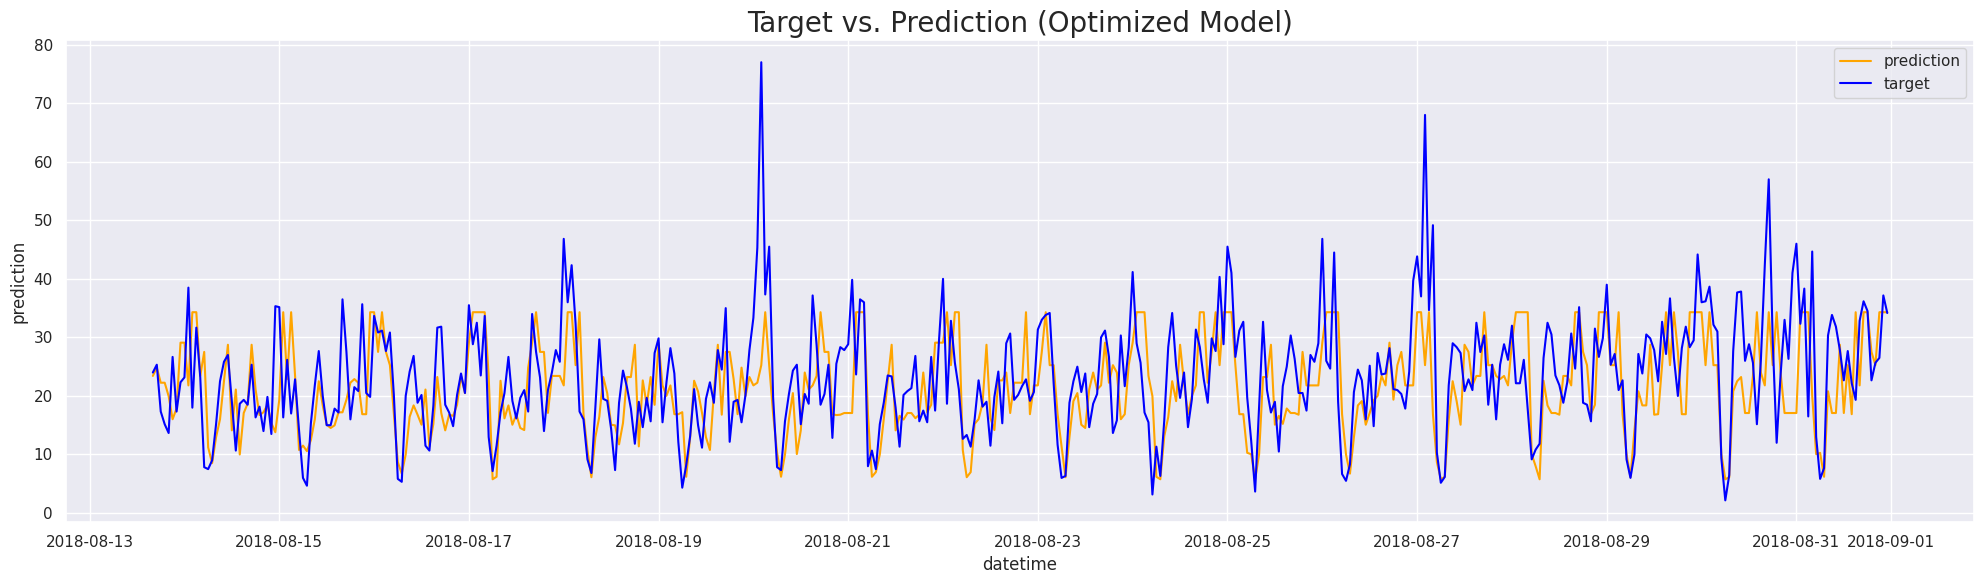

CPU times: user 832 ms, sys: 89.1 ms, total: 921 ms
Wall time: 923 ms


In [25]:
%%time
# Visualizar la evolución de la variable objetivo vs las predicciones
series_preds_optimized = pd.DataFrame(data={
    "prediction": best_preds_optimized,
    "target": test_set[target],
}, index=test_set.index)

sns.set_theme()

plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_optimized, x=series_preds_optimized.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_optimized, x=series_preds_optimized.index, y="target", label="target", color="blue")
plt.title("Target vs. Prediction (Optimized Model)", size=20)
plt.tight_layout()
plt.show()


Del gráfico podemos ver que las predicciones (línea naranja) siguen de cerca los valores reales (línea azul), lo cual indica que el modelo optimizado está capturando bien las tendencias y patrones en los datos.

La precisión es especialmente notable en períodos de demanda más baja y moderada.

Aunque hay algunos picos y valles donde las predicciones no capturan completamente los valores reales, la discrepancia es menor en comparación con el modelo inicial.

En términos generales, el RMSE de 9.0739 y la visualización indican que el modelo optimizado tiene un buen rendimiento general y es capaz de predecir el número de pedidos de taxis con una precisión razonable.

### Modelo Regresión Lineal.

A continuación continuamos el análisis en base al modelo de Regresión Lineal.

In [37]:
# Entrenar el modelo de Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(reduced_train_set[features], reduced_train_set[target])

# Realizar predicciones en el conjunto de prueba
preds_lr = model_lr.predict(test_set[features])

# Evaluar el modelo
rmse_lr = mean_squared_error(test_set[target], preds_lr)**0.5
rmse_lr = round(rmse_lr, 4)
print(f"RMSE del modelo de Regresión Lineal: {rmse_lr}")

RMSE del modelo de Regresión Lineal: 8.0111


Se entrenó un modelo de regresión lineal utilizando los datos sin escalar.
El RMSE obtenido fue 8.0111.
El modelo de regresión lineal superó al modelo de árbol de decisión en términos de RMSE, indicando que, para este conjunto de datos, la regresión lineal es más precisa en la predicción del número de pedidos de taxis.

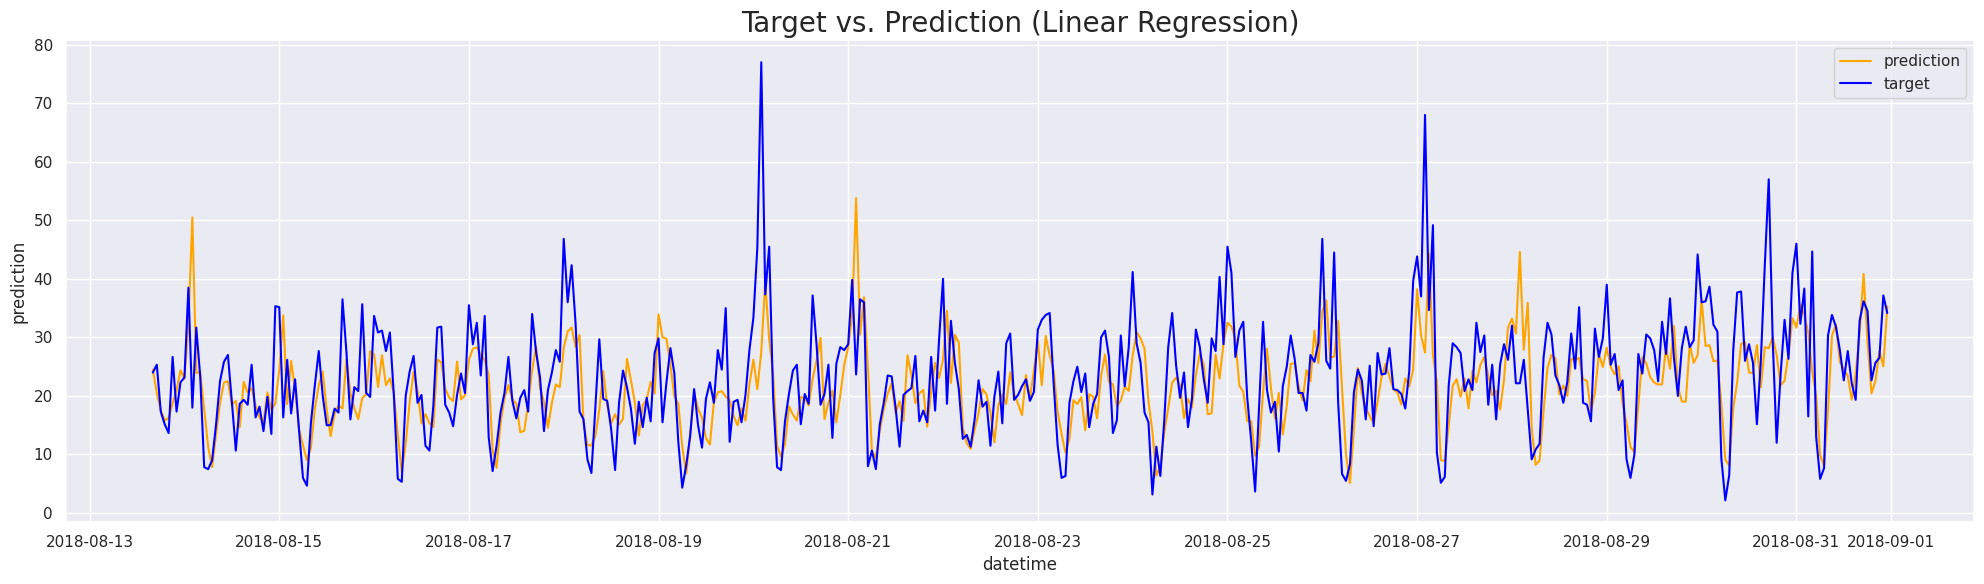

In [38]:
# Visualizar la evolución de la variable objetivo vs las predicciones
series_preds_lr = pd.DataFrame(data={
    "prediction": preds_lr,
    "target": test_set[target],
}, index=test_set.index)

sns.set_theme()

plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_lr, x=series_preds_lr.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_lr, x=series_preds_lr.index, y="target", label="target", color="blue")
plt.title("Target vs. Prediction (Linear Regression)", size=20)
plt.tight_layout()
plt.show()

  <div class="alert alert-block alert-success">


 <b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Procedimiento similar al anterior, excelente nuevamente Enrique!

Las predicciones (línea naranja) siguen de cerca los valores reales (línea azul), lo cual indica que el modelo de regresión lineal está capturando bien las tendencias generales.
Sin embargo, hay algunas discrepancias, especialmente en los picos más altos y los valles más profundos.

### Modelo Bosque Aleatorio.

A continuación continuamos el análisis en base al modelo de Bosque Aleatorio.

In [29]:
%%time

# Inicializar el mejor puntaje y los mejores hiperparámetros
max_score = float('inf')
best_params = {'n_estimators': None, 'max_depth': None}

# Bucle para ajustar los hiperparámetros
for n_estimators in [50, 100, 200]:
    for max_depth in [None, 10, 20]:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(reduced_train_set[features], reduced_train_set[target])
        y_pred_rf = model.predict(valid_set[features])
        score = mean_squared_error(valid_set[target], y_pred_rf)**0.5

        if score < max_score:
            max_score = score
            best_params['n_estimators'] = n_estimators
            best_params['max_depth'] = max_depth
            print(f"""
            N estimators: {n_estimators}
            Max depth: {max_depth}
            RMSE: {round(score, 4)}
            """)



            N estimators: 50
            Max depth: None
            RMSE: 5.988
            

            N estimators: 50
            Max depth: 10
            RMSE: 5.9796
            

            N estimators: 100
            Max depth: None
            RMSE: 5.9589
            

            N estimators: 200
            Max depth: None
            RMSE: 5.9567
            
CPU times: user 27.1 s, sys: 51.9 ms, total: 27.2 s
Wall time: 27.2 s


In [30]:
%%time

# Entrenar el modelo con los mejores hiperparámetros encontrados
model_rf_best = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
model_rf_best.fit(train_set[features], train_set[target])
y_pred_rf_best = model_rf_best.predict(test_set[features])

# Evaluar el modelo optimizado
rmse_rf_best = mean_squared_error(test_set[target], y_pred_rf_best)**0.5
rmse_rf_best = round(rmse_rf_best, 4)
print(f"""
Optimized Random Forest performance:
RMSE: {rmse_rf_best}
""")


Optimized Random Forest performance:
RMSE: 7.7302

CPU times: user 6.43 s, sys: 35.4 ms, total: 6.46 s
Wall time: 6.47 s


El modelo optimizado de Bosque Aleatorio (RMSE: 7.7302) supera al modelo de Regresión Lineal (RMSE: 8.0111) y al modelo de Árbol de Decisión (RMSE: 9.0739).

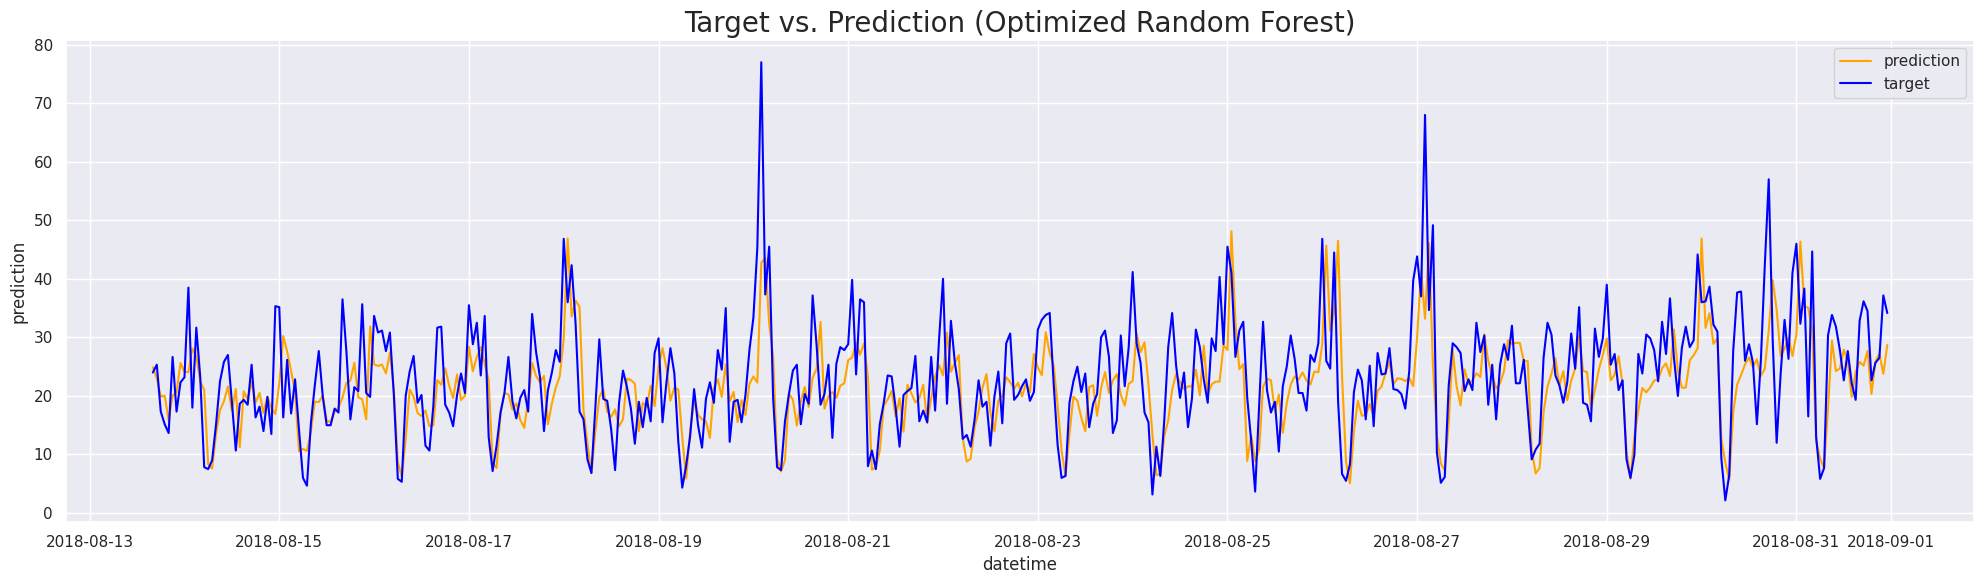

In [31]:
# Visualizar la evolución de la variable objetivo vs las predicciones
series_preds_rf = pd.DataFrame(data={
    "prediction": y_pred_rf_best,
    "target": test_set[target],
}, index=test_set.index)

sns.set_theme()

plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_rf, x=series_preds_rf.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_rf, x=series_preds_rf.index, y="target", label="target", color="blue")
plt.title("Target vs. Prediction (Optimized Random Forest)", size=20)
plt.tight_layout()
plt.show()


Las predicciones (línea naranja) están bastante alineadas con los valores reales (línea azul), lo que indica que el modelo de Bosque Aleatorio optimizado está capturando bien las tendencias generales en los datos.

Hay una buena correspondencia entre los picos y valles de las predicciones y los valores reales, aunque con algunas discrepancias menores.

El modelo de Bosque Aleatorio optimizado parece manejar bien las fluctuaciones en los datos, mostrando un ajuste más preciso que el modelo de Regresión Lineal.

Aún hay algunos picos donde el modelo no captura completamente la magnitud, pero en general, el ajuste es bastante bueno.

El RMSE de 7.7302 confirma que el modelo de Bosque Aleatorio optimizado tiene un mejor rendimiento que los modelos anteriores.


### Modelo LightGBM.

Primero realizamos la ejecución de un Modelo Simple de LightGBM

In [32]:
%%time

# Definir el modelo de LightGBM
model_lgb = lgb.LGBMRegressor(random_state=42)

# Entrenar el modelo
model_lgb.fit(reduced_train_set[features], reduced_train_set[target])

# Realizar predicciones en el conjunto de validación
preds_lgb = model_lgb.predict(valid_set[features])
rmse_lgb = mean_squared_error(valid_set[target], preds_lgb)**0.5
rmse_lgb = round(rmse_lgb, 4)
print(f"RMSE del modelo de LightGBM en el conjunto de validación: {rmse_lgb}")

# Entrenar el modelo optimizado con el conjunto de entrenamiento completo
model_lgb.fit(train_set[features], train_set[target])
y_pred_lgb_best = model_lgb.predict(test_set[features])

# Evaluar el modelo optimizado en el conjunto de prueba
rmse_lgb_best = mean_squared_error(test_set[target], y_pred_lgb_best)**0.5
rmse_lgb_best = round(rmse_lgb_best, 4)
print(f"RMSE del modelo de LightGBM optimizado: {rmse_lgb_best}")



RMSE del modelo de LightGBM en el conjunto de validación: 6.0108
RMSE del modelo de LightGBM optimizado: 7.7244
CPU times: user 938 ms, sys: 12.9 ms, total: 951 ms
Wall time: 881 ms


Ahora procederemos a utilizar GridSearchCV para optimizar los hiperparámetros del modelo LightGBM.

In [33]:
%%time

# Definimos un conjunto de hiperparámetros para la búsqueda
param_grid_lgb = {
    'num_leaves': [31, 40],
    'max_depth': [10, 20],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}

# Realizamos la búsqueda con GridSearchCV
grid_search_lgb = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_grid_lgb,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Entrenamos el GridSearchCV
grid_search_lgb.fit(reduced_train_set[features], reduced_train_set[target])

# Obtenemos el mejor modelo
best_model_lgb = grid_search_lgb.best_estimator_

# Imprimimos los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados: {grid_search_lgb.best_params_}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores hiperparámetros encontrados: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31}
CPU times: user 27.8 s, sys: 482 ms, total: 28.3 s
Wall time: 28.5 s


In [34]:
%%time

# Realizamos predicciones en el conjunto de validación
preds_lgb_valid = best_model_lgb.predict(valid_set[features])
rmse_lgb_valid = mean_squared_error(valid_set[target], preds_lgb_valid)**0.5
rmse_lgb_valid = round(rmse_lgb_valid, 4)
print(f"RMSE del modelo de LightGBM en el conjunto de validación con hiperparámetros optimizados: {rmse_lgb_valid}")

# Entrenamos el modelo optimizado con el conjunto de entrenamiento completo
best_model_lgb.fit(train_set[features], train_set[target])
preds_lgb_test = best_model_lgb.predict(test_set[features])

# Evaluamos el modelo optimizado en el conjunto de prueba
rmse_lgb_test = mean_squared_error(test_set[target], preds_lgb_test)**0.5
rmse_lgb_test = round(rmse_lgb_test, 4)
print(f"RMSE del modelo de LightGBM optimizado en el conjunto de prueba: {rmse_lgb_test}")


RMSE del modelo de LightGBM en el conjunto de validación con hiperparámetros optimizados: 5.8717
RMSE del modelo de LightGBM optimizado en el conjunto de prueba: 7.6917
CPU times: user 396 ms, sys: 7.89 ms, total: 404 ms
Wall time: 334 ms


El modelo de LightGBM optimizado obtuvo un RMSE de 7.6917 en el conjunto de prueba.

Este RMSE es menor que el obtenido por el modelo de Bosque Aleatorio optimizado (RMSE: 7.7302) y el modelo de Regresión Lineal (RMSE: 8.0111).


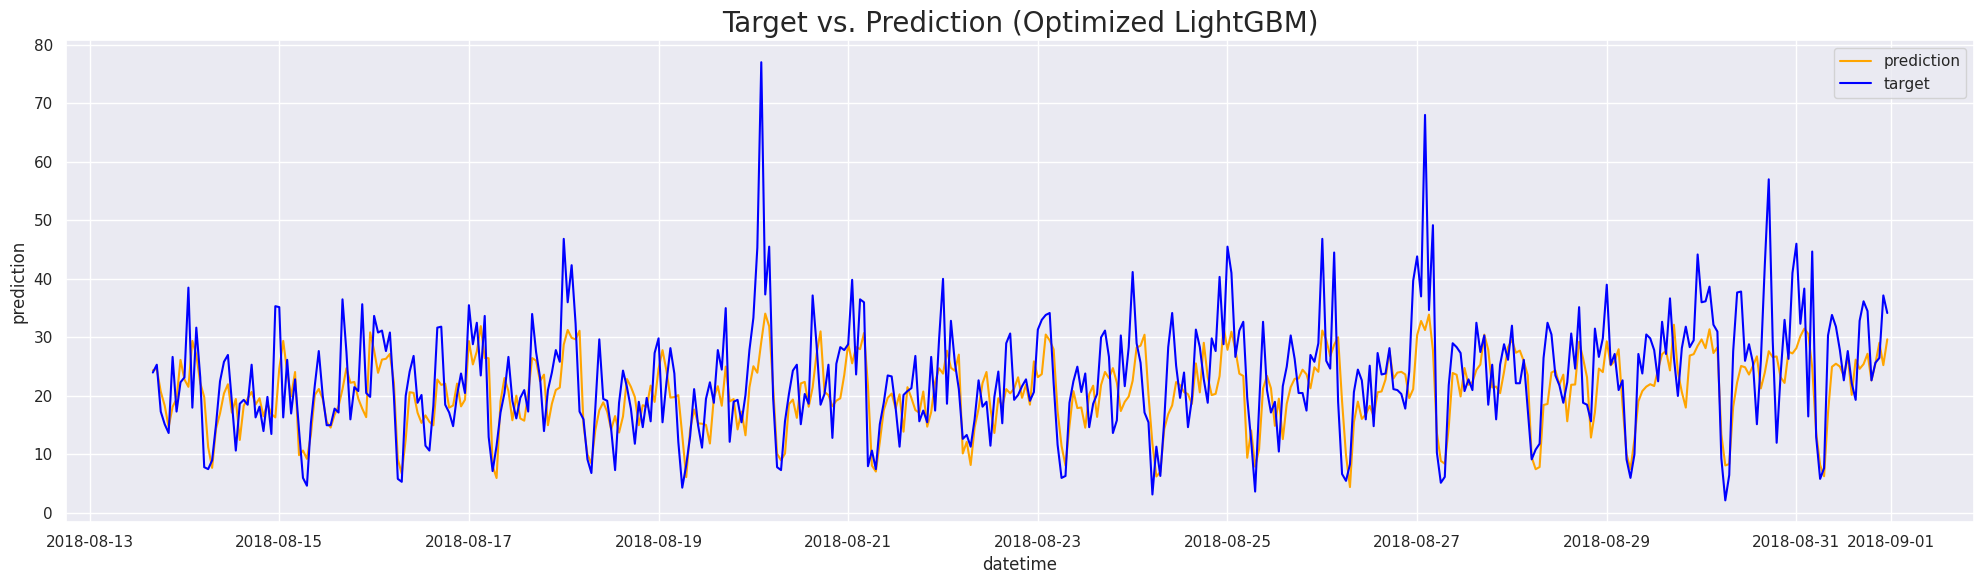

In [35]:

# Visualizar la evolución de la variable objetivo vs las predicciones
series_preds_lgb = pd.DataFrame(data={
    "prediction": preds_lgb_test,
    "target": test_set[target],
}, index=test_set.index)

sns.set_theme()

plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_lgb, x=series_preds_lgb.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_lgb, x=series_preds_lgb.index, y="target", label="target", color="blue")
plt.title("Target vs. Prediction (Optimized LightGBM)", size=20)
plt.tight_layout()
plt.show()


Las predicciones (línea naranja) están bien alineadas con los valores reales (línea azul), indicando que el modelo de LightGBM optimizado está capturando adecuadamente las tendencias generales en los datos.

La correspondencia entre los picos y valles de las predicciones y los valores reales es notablemente buena, mostrando un ajuste preciso.

El RMSE de 7.6917 confirma que el modelo de LightGBM optimizado tiene el mejor rendimiento en comparación con los otros modelos evaluados.

## Conclusión General


El análisis y modelado de series temporales son esenciales en diversas industrias. En el caso de Sweet Lift Taxi, permite anticipar picos en la demanda de taxis, mejorando la planificación y asignación de recursos.

El pronóstico preciso basado en series temporales permite a las empresas tomar decisiones informadas, optimizando la operación y mejorando la satisfacción del cliente. En el caso de los taxis, saber cuándo y dónde habrá mayor demanda permite una mejor distribución de los vehículos, reduciendo tiempos de espera y aumentando la eficiencia operativa.

El modelo de LightGBM optimizado es el más preciso en términos de RMSE, superando tanto al modelo de Regresión Lineal como al modelo de Bosque Aleatorio y al modelo de Árbol de Decisión.

Podemos concluir que el modelo de LightGBM optimizado ofrece el mejor rendimiento para predecir el número de pedidos de taxis en las próximas horas.

La búsqueda y ajuste de hiperparámetros fueron cruciales para mejorar el rendimiento de los modelos, especialmente en el caso de LightGBM y bosque aleatorio.

